# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [2]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [3]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print(scores)
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

[ 0.    0.09]
Total score (averaged over agents) this episode: 0.04500000085681677
[ 0.   -0.01]
Total score (averaged over agents) this episode: -0.004999999888241291
[ 0.   -0.01]
Total score (averaged over agents) this episode: -0.004999999888241291
[ 0.   -0.01]
Total score (averaged over agents) this episode: -0.004999999888241291
[ 0.   -0.01]
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [ ]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pdb


'''
Begin help functions
'''


def hidden_init(layer):
    # source: The other layers were initialized from uniform distributions
    # [− 1/sqrt(f) , 1/sqrt(f) ] where f is the fan-in of the layer
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

'''
End help functions
'''


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=512,
                 fc2_units=256):
        """Initialize parameters and build model.
        :param state_size: int. Dimension of each state
        :param action_size: int. Dimension of each action
        :param seed: int. Random seed
        :param fc1_units: int. Number of nodes in first hidden layer
        :param fc2_units: int. Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        # source: The low-dimensional networks had 2 hidden layers
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc1))
        # source: The final layer weights and biases of the actor and were
        # initialized from a uniform distribution [−3 × 10−3, 3 × 10−3]
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """
        Build an actor (policy) network that maps states -> actions.
        """
        # source: used the rectified non-linearity for all hidden layers
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        # source The final output layer of the actor was a tanh layer,
        # to bound the actions
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, nb_agents, seed,
                 fcs1_units=512, fc2_units=256):
        """Initialize parameters and build model.
        :param state_size: int. Dimension of each state
        :param action_size: int. Dimension of each action
        :param seed: int. Random seed
        :param fcs1_units: int. Nb of nodes in the first hiddenlayer
        :param fc2_units: int. Nb of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear((state_size+action_size)*nb_agents, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        # source: The final layer weights and biases of the critic were
        # initialized from a uniform distribution [3 × 10−4, 3 × 10−4]
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """
        Build a critic (value) network that maps
        (state, action) pairs -> Q-values
        :param state: tuple.
        :param action: tuple.
        """
        xs = torch.cat((state, action.float()), dim=1)
        x = F.relu(self.fcs1(xs))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [7]:
import numpy as np
import random
import copy
import os
import yaml
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim


BATCH_SIZE = 200
BUFFER_SIZE = 100000
GAMMA = 0.99
LR_ACTOR = 0.0001
LR_CRITIC = 0.0003
TAU = 0.001
UPDATE_EVERY = 4
DEVC = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



class MultiAgent(object):
    '''
    '''

    def __init__(self, state_size, action_size, nb_agents, rand_seed):
        '''Initialize an MultiAgent object.
        :param state_size: int. dimension of each state
        :param action_size: int. dimension of each action
        :param nb_agents: int. number of agents to use
        :param rand_seed: int. random seed
        '''
        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE,
                                   BATCH_SIZE, rand_seed)
        self.__name__ = 'MADDPG'
        self.nb_agents = nb_agents
        self.na_idx = np.arange(self.nb_agents)
        self.action_size = action_size
        self.act_size = action_size * nb_agents
        self.state_size = state_size * nb_agents
        self.l_agents = [Agent(state_size,
                               action_size,
                               rand_seed,
                               self)
                         for i in range(nb_agents)]

    def step(self, states, actions, rewards, next_states, dones):
        experience = zip(self.l_agents, states, actions, rewards, next_states,
                         dones)
        for i, e in enumerate(experience):
            agent, state, action, reward, next_state, done = e
            na_filtered = self.na_idx[self.na_idx != i]
            others_states = states[na_filtered]
            others_actions = actions[na_filtered]
            others_next_states = next_states[na_filtered]
            agent.step(state, action, reward, next_state, done, others_states,
                       others_actions, others_next_states)

    def act(self, states, add_noise=True):
        na_rtn = np.zeros([self.nb_agents, self.action_size])
        for idx, agent in enumerate(self.l_agents):
            na_rtn[idx, :] = agent.act(states[idx], add_noise)
        return na_rtn

    def reset(self):
        for agent in self.l_agents:
            agent.reset()

    def __len__(self):
        return self.nb_agents

    def __getitem__(self, key):
        return self.l_agents[key]


class Agent(object):
    '''
    Implementation of a DQN agent that interacts with and learns from the
    environment
    '''

    def __init__(self, state_size, action_size, rand_seed, meta_agent):
        '''Initialize an MetaAgent object.
        :param state_size: int. dimension of each state
        :param action_size: int. dimension of each action
        :param nb_agents: int. number of agents to use
        :param rand_seed: int. random seed
        :param memory: ReplayBuffer object.
        '''

        self.action_size = action_size
        self.__name__ = 'DDPG'

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, rand_seed).to(DEVC)
        self.actor_target = Actor(state_size, action_size, rand_seed).to(DEVC)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(),
                                          lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size,
                                   action_size,
                                   meta_agent.nb_agents,
                                   rand_seed).to(DEVC)
        self.critic_target = Critic(state_size,
                                    action_size,
                                    meta_agent.nb_agents,
                                    rand_seed).to(DEVC)
        # NOTE: the decay corresponds to L2 regularization
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(),
                                           lr=LR_CRITIC)  # , weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, rand_seed)

        # Replay memory
        self.memory = meta_agent.memory

        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done, others_states,
             others_actions, others_next_states):
        self.memory.add(state, action, reward, next_state, done, others_states,
                        others_actions, others_next_states)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset
            # and learn
            if len(self.memory) > BATCH_SIZE:
                # source: Sample a random minibatch of N transitions from R
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, states, add_noise=True):
        '''Returns actions for given states as per current policy.
        :param states: array_like. current states
        :param add_noise: Boolean. If should add noise to the action
        '''
        states = torch.from_numpy(states).float().to(DEVC)
        self.actor_local.eval()
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
        self.actor_local.train()
        # source: Select action at = μ(st|θμ) + Nt according to the current
        # policy and exploration noise
        if add_noise:
            actions += self.noise.sample()
        return np.clip(actions, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        '''
        Update policy and value params using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        :param experiences: Tuple[torch.Tensor]. tuple of (s, a, r, s', done)
        :param gamma: float. discount factor
        '''
        (states, actions, rewards, next_states, dones, others_states,
         others_actions, others_next_states) = experiences
        # rewards_ = torch.clamp(rewards, min=-1., max=1.)
        rewards_ = rewards
        all_states = torch.cat((states, others_states), dim=1).to(DEVC)
        all_actions = torch.cat((actions, others_actions), dim=1).to(DEVC)
        all_next_states = torch.cat((next_states, others_next_states), dim=1).to(DEVC)

        # --------------------------- update critic ---------------------------
        # Get predicted next-state actions and Q values from target models
        l_all_next_actions = []
        l_all_next_actions.append(self.actor_target(states))
        l_all_next_actions.append(self.actor_target(others_states))
        all_next_actions = torch.cat(l_all_next_actions, dim=1).to(DEVC)

        Q_targets_next = self.critic_target(all_next_states, all_next_actions)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards_ + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss: L = 1/N SUM{(yi − Q(si, ai|θQ))^2}
        Q_expected = self.critic_local(all_states, all_actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        # suggested by Attempt 3, from Udacity
        # torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # --------------------------- update actor ---------------------------
        # Compute actor loss: ∇θμ J ≈1/N  ∇aQ(s, a|θQ)|s=si,a=μ(si)∇θμ μ(s|θμ)
        this_actions_pred = self.actor_local(states)
        others_actions_pred = self.actor_local(others_states)
        others_actions_pred = others_actions_pred.detach()
        actions_pred = torch.cat((this_actions_pred, others_actions_pred), dim=1).to(DEVC)
        actor_loss = -self.critic_local(all_states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ---------------------- update target networks ----------------------
        # Update the critic target networks: θQ′ ←τθQ +(1−τ)θQ′
        # Update the actor target networks: θμ′ ←τθμ +(1−τ)θμ′
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        '''Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        :param local_model: PyTorch model. weights will be copied from
        :param target_model: PyTorch model. weights will be copied to
        :param tau: float. interpolation parameter
        '''
        iter_params = zip(target_model.parameters(), local_model.parameters())
        for target_param, local_param in iter_params:
            tensor_aux = tau*local_param.data + (1.0-tau)*target_param.data
            target_param.data.copy_(tensor_aux)

    def reset(self):
        self.noise.reset()


class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.size = size
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x)
        # dx += self.sigma * np.random.rand(*self.size)  # Uniform disribution
        dx += self.sigma * np.random.randn(self.size)  # normal distribution
        # dx += self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state


class ReplayBuffer(object):
    '''Fixed-size buffer to store experience tuples.'''

    def __init__(self, action_size, buffer_size, batch_size, seed):
        '''Initialize a ReplayBuffer object.
        :param action_size: int. dimension of each action
        :param buffer_size: int: maximum size of buffer
        :param batch_size (int): size of each training batch
        :param seed (int): random seed
        '''
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience",
                                     field_names=["state", "action", "reward",
                                                  "next_state", "done",
                                                  "others_states",
                                                  "others_actions",
                                                  "others_next_states"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done, others_states,
            others_actions, others_next_states):
        '''Add a new experience to memory.'''
        e = self.experience(state, action, reward, next_state, done,
                            others_states, others_actions, others_next_states)
        self.memory.append(e)

    def sample(self):
        '''Randomly sample a batch of experiences from memory.'''
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences
                                  if e is not None])).float().to(DEVC)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences
                                   if e is not None])).float().to(DEVC)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences
                                   if e is not None])).float().to(DEVC)
        next_states = torch.from_numpy(np.vstack([e.next_state
                                                  for e in experiences
                                                  if e is not None])).float().to(DEVC)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences
                                            if e is not None]).astype(np.uint8)).float().to(DEVC)

        others_states = torch.from_numpy(np.vstack([e.others_states for e in experiences
                                  if e is not None])).float().to(DEVC)
        others_actions = torch.from_numpy(np.vstack([e.others_actions for e in experiences
                                   if e is not None])).float().to(DEVC)
        others_next_states = torch.from_numpy(np.vstack([e.others_next_states
                                                      for e in experiences
                                                      if e is not None])).float().to(DEVC)

        return (states, actions, rewards, next_states, dones, others_states,
                others_actions, others_next_states)

    def __len__(self):
        '''Return the current size of internal memory.'''
        return len(self.memory)

In [11]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents 
Num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
Action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
State_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24


In [12]:
ma = MultiAgent(State_size , Action_size , Num_agents , 0)

def ddpg(n_episodes=10000, max_t=500):
    all_scores = []
    scores_window = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes+1):
        
#         ma.reset()
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations           
        scores = np.zeros(num_agents)

        for i in range(max_t):
            actions = ma.act(states)
            env_info = env.step(actions)[brain_name]
            rewards = env_info.rewards
            next_states = env_info.vector_observations
            dones = env_info.local_done

            ma.step(states, actions, rewards, next_states, dones)

            scores += rewards
            states = next_states
            
        avg_score = np.mean(scores)
        scores_window.append(avg_score)
        all_scores.append(avg_score)
        
        print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode-5, np.mean(scores_window)))
            torch.save(ma.l_agents[0].actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(ma.l_agents[0].critic_local.state_dict(), 'checkpoint_critic.pth')
            break 
            
    return all_scores

all_score = ddpg()

Episode 100	Average Score: -0.029
Episode 169	Average Score: 0.5031
Environment solved in 164 episodes!	Average Score: 0.503


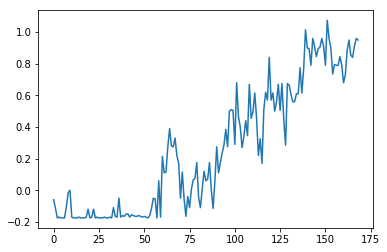

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(all_score)